# __Step 4.2: Topic model tuning__

BERTopic 
- [Step-by-step](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)
- [Deal with situation where most docs are in the -1 topic](https://github.com/MaartenGr/BERTopic/issues/485)

## ___Set up___

### Module import

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from bertopic import BERTopic

### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "4_topic_model/4_2_tuning"
work_dir.mkdir(parents=True, exist_ok=True)

# plant science corpus
dir25       = proj_dir / "2_text_classify/2_5_predict_pubmed"
corpus_file = dir25 / "corpus_plant_421658.tsv.gz"

# processed docs
dir41            = proj_dir / "4_topic_model/4_1_get_topics"
docs_clean_file  = dir41 / "corpus_plant_421658_proc_txt.pkl"

# embedding model
emb_model_name = "allenai/scibert_scivocab_uncased" 


## ___Load data and get embeddings___

### Load cleaned data

In [3]:
with open(docs_clean_file, "rb") as f:
  docs_clean = pickle.load(f)

In [4]:
len(docs_clean), docs_clean[0]

(421658,
 'identification 120 mus phase decay delayed fluorescence spinach chloroplasts subchloroplast particles intrinsic back reaction . dependence level phase thylakoids internal ph . 500 mus laser flash 120 mus phase decay delayed fluorescence visible variety circumstances spinach chloroplasts subchloroplast particles enriched photosystem ii prepared means digitonin . level phase high case inhibition oxygen evolution donor side photosystem ii . comparison results babcock sauer ( 1975 ) biochim . bio-phys . acta 376 , 329-344 , indicates epr signal iif suppose due z+ , oxidized first secondary donor photosystem ii , well correlated large amplitude 120 mus phase . explain 120 mus phase intrinsic back reaction excited reaction center presence z+ , predicted van gorkom donze ( 1973 ) photochem . photobiol . 17 , 333-342. redox state z+ dependent internal ph thylakoids . results effect ph mus region compared obtained ms region .')

### Get doc embeddings 

In [5]:
emb_model = SentenceTransformer(emb_model_name)

No sentence-transformers model found with name /home/shius/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/shius/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly id

In [6]:
embeddings = emb_model.encode(docs_clean, show_progress_bar=True)

Batches:   0%|          | 0/13177 [00:00<?, ?it/s]

In [7]:
# Output embeddings
with open(work_dir / "embeddings_scibert.pickle", "wb") as f:
  pickle.dump(embeddings, f)

In [5]:
# Load embeddings
with open(work_dir / "embeddings_scibert.pickle", "rb") as f:
  embeddings = pickle.load(f)

In [6]:
type(embeddings), embeddings.shape

(numpy.ndarray, (421658, 768))

## ___Run BERTopic___

### Set parameters

In [7]:
# HDBSCAN clustering setting
min_cluster_size         = 500 
metric                   = 'euclidean' 
cluster_selection_method ='eom' 
prediction_data          = True 
min_samples              = 5

# BERTopic setting
calculate_probabilities = True
n_neighbors             = 10  
nr_topics               = 500
n_gram_range            = (1,2)

### Initialize HDBSCAN

For reducing outliers, following [this instruction](https://maartengr.github.io/BERTopic/faq.html#how-do-i-reduce-topic-outliers)
- Also see [HDBSCAN doc](https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html#what-about-different-metrics)
- Comparison of [distance metrics](https://www.kdnuggets.com/2019/01/comparison-text-distance-metrics.html)

In [9]:
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, 
                        metric=metric, 
                        cluster_selection_method=cluster_selection_method, 
                        prediction_data=prediction_data, 
                        min_samples=min_samples)

### Intialize and train topic model

In [16]:
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                       calculate_probabilities=calculate_probabilities,
                       n_gram_range=n_gram_range,
                       nr_topics=nr_topics,
                       verbose=True)

In [17]:
topics, probs = topic_model.fit_transform(docs_clean,
                                          embeddings)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2022-07-20 15:10:02,980 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2022-07-20 15:14:40,126 - BERTopic - Clustered reduced embeddings
2022-07-20 15:21:22,908 - BERTopic - Reduced number of topics from 91 to 91


### Save model, topics, and probability

In [10]:
# I already save the embeddings, so won't save it again
topic_model.save(work_dir / 'topic_model')

with open(work_dir / 'probs.pickle', "wb") as f:
  pickle.dump(probs, f)

In [9]:
# Load topic model
topic_model = BERTopic.load(work_dir / 'topic_model')

# load prob
with open(work_dir / 'probs.pickle', "rb") as f:
  probs = pickle.load(f)

In [11]:
help(topic_model)

Help on BERTopic in module bertopic._bertopic object:

class BERTopic(builtins.object)
 |  BERTopic(language: str = 'english', top_n_words: int = 10, n_gram_range: Tuple[int, int] = (1, 1), min_topic_size: int = 10, nr_topics: Union[int, str] = None, low_memory: bool = False, calculate_probabilities: bool = False, diversity: float = None, seed_topic_list: List[List[str]] = None, embedding_model=None, umap_model: umap.umap_.UMAP = None, hdbscan_model: hdbscan.hdbscan_.HDBSCAN = None, vectorizer_model: sklearn.feature_extraction.text.CountVectorizer = None, verbose: bool = False)
 |  
 |  BERTopic is a topic modeling technique that leverages BERT embeddings and
 |  c-TF-IDF to create dense clusters allowing for easily interpretable topics
 |  whilst keeping important words in the topic descriptions.
 |  
 |  The default embedding model is `all-MiniLM-L6-v2` when selecting `language="english"` 
 |  and `paraphrase-multilingual-MiniLM-L12-v2` when selecting `language="multilingual"`.
 |  


In [9]:
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name
0,-1,241567,-1_plant_plants_species_growth
1,0,919,0_allergen_allergens_pollen_ige
2,1,3976,1_medium_callus_regeneration_culture
3,2,1111,2_dots_fluorescence_detection_carbon dots
4,3,859,3_glyphosate_herbicide_resistance_herbicides
...,...,...,...
86,85,825,85_soil_yield_nitrogen_fertilizer
87,86,567,86_inbreeding_depression_inbreeding depression...
88,87,2828,87_pollen_pollination_flowers_floral
89,88,1849,88_populations_genetic_diversity_genetic diver...


## ___Assign outliers to topics___

### Determine probability distributions of outliers

In [11]:
probs.shape, probs[:,0].shape

((421658, 90), (421658,))

,0
count,4.216580e+05
mean,4.686914e-03
std,3.724943e-02
min,4.414574e-308
25%,1.323693e-03
50%,2.881805e-03
75%,4.384614e-03
max,1.000000e+00


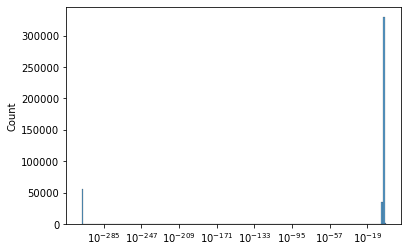

In [12]:
sns.histplot(probs[:,0], bins=200, log_scale=True)
pd.DataFrame(probs[:,0]).describe()

,0
count,4.216580e+05
mean,6.411141e-03
std,4.244737e-02
min,5.014457e-308
25%,1.727241e-03
50%,4.033303e-03
75%,5.625952e-03
max,1.000000e+00


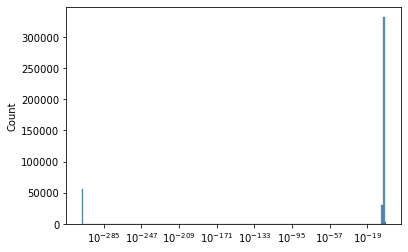

In [13]:
sns.histplot(probs[:,1], bins=200, log_scale=True)
pd.DataFrame(probs[:,1]).describe()

### Assignments

In [14]:
probability_threshold = 0.01
new_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 
                                                            for prob in probs]

In [16]:
# ~8 min
topic_model.update_topics(docs_clean, new_topics)

In [45]:
topic_model.save(work_dir / 'topic_model_updated')

In [ ]:
topic_info_updated = topic_model.get_topic_info()
topic_info_updated